# MNIST

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Package name: scikit-image, requires installation of package 'Pillow'
import skimage.io
import skimage.transform
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

def train_model(model, dataset, validation_set, learning_rate, batch_size, epochs, f=F.cross_entropy): 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #ToDo: lr scheduler instead of lr fix
    epoch_losses = []
    validation_losses = []

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_data_loader = data.DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = f(yhat, batch['y'].long())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        # Epoch ended, save values for later plotting and print information
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')
        epoch_losses.append(epoch_loss)
        
        # Calculate validation loss
        validation_loss = 0
        for batch in val_data_loader:
            model.zero_grad()
            yhat = model.forward(batch['X'].float())
            batch_loss = f(yhat, batch['y'].long())
            validation_loss += batch_loss.item()
        validation_losses.append(validation_loss)
        
    return epoch_losses, validation_losses
            


#Some methods for evaluating results
def get_confusion_matrix(y_pred, y_true, n_classes):
    assert len(y_pred) == len(y_true)
    results = np.zeros(shape=(n_classes, n_classes))
    for i in range(len(y_pred)):
        results[y_pred[i], y_true[i]] += 1
    return results
    
def precision(y_pred, y_true, n_classes):
    precision = np.zeros(shape=n_classes)
    confusion_matrix = get_confusion_matrix(y_pred, y_true, n_classes)
    for i in range(n_classes):
        sum_of_row = confusion_matrix[i].sum()
        if confusion_matrix[i, i] != 0:
            precision[i] = confusion_matrix[i, i] / sum_of_row
    return precision

def recall(y_pred, y_true, n_classes):
    recall = np.zeros(shape=n_classes)
    confusion_matrix = get_confusion_matrix(y_pred, y_true, n_classes)
    for i in range(n_classes):
        sum_of_column = confusion_matrix[:,i].sum()
        if confusion_matrix[i, i] != 0:
            recall[i] = confusion_matrix[i, i] / sum_of_column
    return recall

def f1score(y_pred, y_true, n_classes):
    p = precision(y_pred, y_true, n_classes)
    r = recall(y_pred, y_true, n_classes)
    f1 = np.zeros(shape=n_classes)
    for i in range(n_classes):
        if r[i] + p[i] != 0:
            f1[i] = 2 * p[i] * r[i] / (r[i] + p[i])
    return f1

## Prepare Data

In [2]:
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
print(mnist_trainset)
print(mnist_testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
def to_rgb(x_grey: torch.Tensor) -> torch.Tensor:
    helper = torch.unsqueeze(x_grey, 1)
    return helper.repeat(1, 3, 1, 1).float()

X_train_grey = mnist_trainset.train_data
X_train = to_rgb(X_train_grey)
X_test_grey = mnist_testset.test_data
X_test = to_rgb(X_test_grey)
y_train = mnist_trainset.train_labels
y_test = mnist_testset.test_labels
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


X_train: torch.Size([60000, 3, 28, 28]) 60000
X_test: torch.Size([10000, 3, 28, 28])
y_train: torch.Size([60000])
y_test: torch.Size([10000])


C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\robin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Training

In [4]:
# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 2
n_classes = 10

In [5]:
from torchvision import models

debugg = False

resnet = models.resnet18(pretrained=False)
in_ftr = resnet.fc.in_features
out_ftr = n_classes
resnet.fc = nn.Linear(in_ftr,out_ftr,bias=True)
if debugg:
    yhat = resnet.forward(X_test)
    print(yhat.shape)
    
dataset_train = BasicDataset(X_train, y_train)
dataset_test = BasicDataset(X_test, y_test)
training_loss, validation_loss = train_model(resnet, dataset_train, dataset_test, learning_rate, batch_size, epochs)

C:\Users\robin\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\robin\anaconda3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


Epoch 1/2 - Loss: 183.2266472429037
Epoch 2/2 - Loss: 73.31381904950831


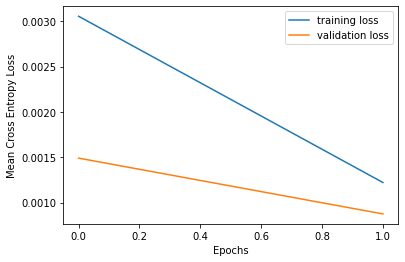

In [13]:
plt.plot(np.array(training_loss) / len(X_train), label='training loss')
plt.plot(np.array(validation_loss) / len(X_test), label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Cross Entropy Loss')
plt.legend()